In [1]:
import torch
import os
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import time
from torchvision import models

In [2]:
base_dir = '/kaggle/input/finding-lungs-in-ct-data'
image_dir = os.path.join(base_dir, '2d_images')
mask_dir = os.path.join(base_dir, '2d_masks')

image_files = sorted([os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tif')])
mask_files = sorted([os.path.join(mask_dir, file) for file in os.listdir(mask_dir) if file.endswith('.tif')])

print(f'Number of image files: {len(image_files)}')
print(f'Number of mask files: {len(mask_files)}')

Number of image files: 267
Number of mask files: 267


In [3]:
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('L')
    transform = transforms.Compose([transforms.ToTensor()])
    image = transform(image)
    image = image.numpy()*255
    return image

def binarize_mask(mask):
    mask_tensor = torch.from_numpy(mask)  # Convert to tensor
    return (mask_tensor > 0.5).float()  # Apply threshold and convert to float


In [4]:
images = torch.stack([torch.from_numpy(load_and_preprocess_image(file)) for file in image_files])
masks = torch.stack([binarize_mask(load_and_preprocess_image(file)) for file in mask_files])

print(f'Images shape: {images.shape}')
print(f'Masks shape: {masks.shape}')



print(f'Images shape: {images.shape}')
print(f'Masks shape: {masks.shape}')
print(f'Images dtype: {images.dtype}')
print(f'Masks dtype: {masks.dtype}')
print(f'Masks min value: {masks.min()}, max value: {masks.max()}')

Images shape: torch.Size([267, 1, 512, 512])
Masks shape: torch.Size([267, 1, 512, 512])
Images shape: torch.Size([267, 1, 512, 512])
Masks shape: torch.Size([267, 1, 512, 512])
Images dtype: torch.float32
Masks dtype: torch.float32
Masks min value: 0.0, max value: 1.0


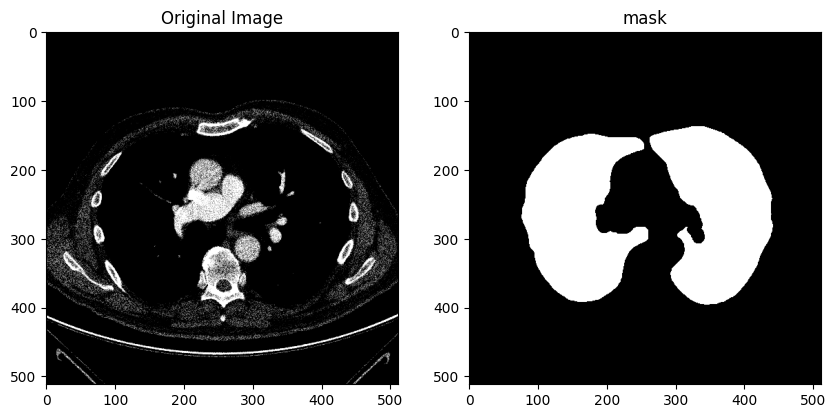

In [5]:
plt.figure(figsize = (10 , 5))
plt.subplot(1,2,1)
plt.imshow(images[0].squeeze().numpy(), cmap = 'gray')
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(masks[0].squeeze().numpy(), cmap = "gray")
plt.title("mask")

plt.show()

In [6]:
sample_image_path = image_files[0]
sample_image = Image.open(sample_image_path)

image_mode = sample_image.mode
input_channels = 1 if image_mode == 'L' else 3

print(f'Image mode: {image_mode}, Input channels: {input_channels}')

Image mode: I, Input channels: 3


In [7]:
# import torch
# from torch.utils.data import Dataset, DataLoader

# # Define the custom dataset class
# class ImageMaskDataset(Dataset):
#     def __init__(self, images, masks):
#         """
#         Args:
#             images (Tensor): A tensor containing the images.
#             masks (Tensor): A tensor containing the corresponding masks.
#         """
#         self.images = images
#         self.masks = masks

#     def __len__(self):
#         # Return the number of samples in the dataset
#         return len(self.images)

#     def __getitem__(self, idx):
#         # Retrieve the image and mask at the given index
#         image = self.images[idx]
#         mask = self.masks[idx]
#         return image, mask

# # Assuming images and masks have already been loaded as tensors
# images = torch.stack([load_and_preprocess_image(file) for file in image_files])
# masks = torch.stack([binarize_mask(load_and_preprocess_image(file)) for file in mask_files])

# # Optional: Print information about images and masks
# print(f'Images shape: {images.shape}')
# print(f'Masks shape: {masks.shape}')
# print(f'Images dtype: {images.dtype}')
# print(f'Masks dtype: {masks.dtype}')
# print(f'Masks min value: {masks.min()}, max value: {masks.max()}')

# # Create the dataset
# dataset = ImageMaskDataset(images, masks)

# # Use DataLoader to iterate through the dataset in batches
# # data_loader = DataLoader(dataset, batch_size=16, shuffle=True)  # Batch size can be adjusted

# # Example usage: Iterate through the data
# # for batch_images, batch_masks in data_loader:
# #     print(f'Batch Images shape: {batch_images.shape}, Batch Masks shape: {batch_masks.shape}')


In [8]:
# dataloader = DataLoader(dataset, batch_size = 8, shuffle = True)
# indices = list(range(len(dataset)))
# train_indices, test_indices = train_test_split(indices, test_size = 0.2, random_state = 42)

# train_subset = Subset(dataset, train_indices)
# test_subset = Subset(dataset, test_indices)


# train_dataloader = DataLoader(train_subset, batch_size = 8, shuffle = True, num_workers = 4)
# test_dataloader = DataLoader(test_subset, batch_size = 8, shuffle = False, num_workers = 4)
# print(len(train_dataloader))

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
class attention_block(nn.Module):
    def __init__(self, g, x, i):
        super(attention_block, self).__init__()
        self.wg = nn.Sequential(
            nn.Conv2d(g, i, kernel_size = 1, stride = 1, padding = 0),
            nn.BatchNorm2d(i)
        )
        self.wx = nn.Sequential(
            nn.Conv2d(x, i, kernel_size=1, stride=1, padding = 0),
            nn.BatchNorm2d(i)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(i,1,kernel_size=1,stride=1,padding=0),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
    def forward(self, g, x):
        g1 = self.wg(g)
        x1 = self.wx(x)
        if g1.size() != x.size():
            g1 = F.interpolate(g1, size = x1.size()[2:], mode = 'bilinear', align_corners = True)
        psi = nn.ReLU()(g1+x1)
        psi = self.psi(psi)
        return psi*x
    

class conv(nn.Module):
    def __init__(self,in_channels,out_channels):
            
        super(conv,self).__init__()
        self.conv2d=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_channels),    
        nn.ReLU(),
        nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_channels),    
        nn.ReLU() 
        )
    def forward(self,x):
        
        x=self.conv2d(x)
        return x
    
class upconv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(upconv,self).__init__()
        self.up=nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.BatchNorm2d(out_channels)  
        )
        
    def forward(self,x):
        x=self.up(x)
        return x
    
class CONV(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(CONV,self).__init__()
        self.conv2d=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=7, stride = 2, padding=3, bias = False),
        nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),    
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        )
    def forward(self,x):
        
        x=self.conv2d(x)
        return x
    
# (e1): Sequential(
#     (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
#     (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#     (2): ReLU(inplace=True)
#     (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
#   )

In [11]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class PyramidPoolingModule(nn.Module):
#     def __init__(self, in_channels, pool_sizes=(1, 2, 3, 6)):
#         super(PyramidPoolingModule, self).__init__()
#         self.pool1 = nn.AdaptiveAvgPool2d(pool_sizes[0])
#         self.pool2 = nn.AdaptiveAvgPool2d(pool_sizes[1])
#         self.pool3 = nn.AdaptiveAvgPool2d(pool_sizes[2])
#         self.pool4 = nn.AdaptiveAvgPool2d(pool_sizes[3])
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(in_channels, in_channels // 4, kernel_size=1, bias=False),
#             nn.BatchNorm2d(in_channels // 4))
#         self.conv2 = nn.Sequential(nn.Conv2d(in_channels, in_channels // 4, kernel_size=1, bias=False),
#                                    nn.BatchNorm2d(in_channels // 4))
#         self.conv3 = nn.Sequential(nn.Conv2d(in_channels, in_channels // 4, kernel_size=1, bias=False),
#                                    nn.BatchNorm2d(in_channels // 4))
#         self.conv4 = nn.Sequential(nn.Conv2d(in_channels, in_channels // 4, kernel_size=1, bias=False),
#                                    nn.BatchNorm2d(in_channels // 4))
#         self.relu = nn.ReLU(inplace=True)

#     def forward(self, x):
#         h, w = x.size(2), x.size(3)
      
#         feat1 = F.interpolate(self.relu(self.conv1(self.pool1(x))), size=(h, w), mode='bilinear', align_corners=True)
#         feat2 = F.interpolate(self.relu(self.conv2(self.pool2(x))), size=(h, w), mode='bilinear', align_corners=True)
#         feat3 = F.interpolate(self.relu(self.conv3(self.pool3(x))), size=(h, w), mode='bilinear', align_corners=True)
#         feat4 = F.interpolate(self.relu(self.conv4(self.pool4(x))), size=(h, w), mode='bilinear', align_corners=True)
       
#         out = torch.cat([x, feat1, feat2, feat3, feat4], dim=1)
#         return out

In [12]:
class PyramidPoolingModule(nn.Module):
    def __init__(self, in_channels,pool_sizes=(1, 2, 3, 6)):
        super(PyramidPoolingModule, self).__init__()
        self.pool1 = nn.AdaptiveAvgPool2d(pool_sizes[0])
        self.pool2 = nn.AdaptiveAvgPool2d(pool_sizes[1])
        self.pool3 = nn.AdaptiveAvgPool2d(pool_sizes[2])
        self.pool4 = nn.AdaptiveAvgPool2d(pool_sizes[3])

        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, kernel_size=1, bias=False)
        self.conv2 = nn.Conv2d(in_channels, in_channels // 4, kernel_size=1, bias=False)
        self.conv3 = nn.Conv2d(in_channels, in_channels // 4, kernel_size=1, bias=False)
        self.conv4 = nn.Conv2d(in_channels, in_channels // 4, kernel_size=1, bias=False)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        h, w = x.size(2), x.size(3)
        
        # Prevent pooling from reducing spatial dimensions too much
        feat1 = F.interpolate(self.relu(self.conv1(self.pool1(x))), size=(h, w), mode='bilinear', align_corners=True)
        feat2 = F.interpolate(self.relu(self.conv2(self.pool2(x))), size=(h, w), mode='bilinear', align_corners=True)
        feat3 = F.interpolate(self.relu(self.conv3(self.pool3(x))), size=(h, w), mode='bilinear', align_corners=True)
        feat4 = F.interpolate(self.relu(self.conv4(self.pool4(x))), size=(h, w), mode='bilinear', align_corners=True)
        
        return torch.cat([x, feat1, feat2, feat3, feat4], dim=1)


In [13]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.resnet = models.resnet50(weights = "IMAGENET1K_V1")
        
        # Encoder
        #self.e1 = nn.Sequential(*list(self.resnet.children())[:4])
        self.e1 = CONV(in_channels, 64)
        self.e2 = self.resnet.layer1
        self.e3 = self.resnet.layer2
        self.e4 = self.resnet.layer3
        
        self.ppm = PyramidPoolingModule(in_channels = 1024)
        
        # Decoder
        self.d1 = upconv(in_channels=2048, out_channels=512)  # adjusted for ppm output
        self.att1 = attention_block(g=512, x=512, i=256)
        self.up_conv1 = conv(in_channels=1024, out_channels=512)

        self.d2 = upconv(in_channels=512, out_channels=256)
        self.att2 = attention_block(g=256, x=256, i=128)
        self.up_conv2 = conv(in_channels=512, out_channels=256)

        self.d4 = upconv(in_channels=256, out_channels=64)
        self.att4 = attention_block(g=64, x=64, i=32)
        self.up_conv4 = conv(in_channels=128, out_channels=64)
        self.up_conv5=upconv(in_channels=64, out_channels=64)
        # Final Convolution
        self.conv1x1 = nn.Conv2d(64, out_channels, kernel_size=1)
        self.max=nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x1 = self.e1(x)  # output: 64
        x2 = self.e2(x1)  # output: 256
        x3 = self.e3(x2)  # output: 512
        x4 = self.e4(x3)  # output: 1024

        
        x4 = self.ppm(x4)  # output: 2048

        # Decoding
        y1 = self.d1(x4)
        x3 = self.att1(y1, x3)
        y1 = torch.cat((x3, y1), dim=1)
        y1 = self.up_conv1(y1)

        y2 = self.d2(y1)
        x2 = self.att2(y2, x2)
        y2 = torch.cat((x2, y2), dim=1)
        y2 = self.up_conv2(y2)

        y4 = self.d4(y2)
        y4=self.max(y4)
        x1 = self.att4(y4, x1)
        y4 = torch.cat((x1, y4), dim=1)
        y4 = self.up_conv4(y4)
        y4 = self.up_conv5(y4)
        y4 = self.up_conv5(y4)
        # Final output
        y5 = self.conv1x1(y4)
        
        return torch.sigmoid(y5)
    
model = UNet(1, 1)
model.to(device)
print(" ")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 166MB/s]


In [14]:
def dice_coefficient(preds, targets):
    smooth = 1.0
    preds = (preds>0.5).float()
    intersection = (preds*targets).sum()
    return (2 * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

In [15]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=50):
    total_start_time = time.time()
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        model.train()
        running_loss = 0.0
        running_dice = 0.0
        running_iou = 0.0
        for images, masks in train_loader:
            images, masks = images.float().to(device), masks.float().to(device)  # float 타입으로 변환

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            running_dice += dice_coefficient(outputs, masks).item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_dice = running_dice / len(train_loader.dataset)
        epoch_iou = running_iou / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        val_iou = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.float().to(device), masks.float().to(device)  # float 타입으로 변환
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)
                val_dice += dice_coefficient(outputs, masks).item() * images.size(0)
        val_loss /= len(val_loader.dataset)
        val_dice /= len(val_loader.dataset)
        val_iou /= len(val_loader.dataset)

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time

        print(f'Epoch {epoch+1}/{num_epochs}, Duration: {epoch_duration:.2f} seconds, '
              f'Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, '
              f'Dice Coefficient: {epoch_dice:.4f}, Validation Dice: {val_dice:.4f}')

    total_end_time = time.time()
    total_duration = total_end_time - total_start_time
    print(f'Total training time: {total_duration:.2f} seconds')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

dataset = torch.utils.data.TensorDataset(images, masks)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5)

Epoch 1/5, Duration: 29.29 seconds, Loss: 0.2031, Validation Loss: 0.6142, Dice Coefficient: 0.8928, Validation Dice: 0.1149
Epoch 2/5, Duration: 28.99 seconds, Loss: 0.1014, Validation Loss: 0.1103, Dice Coefficient: 0.9543, Validation Dice: 0.9611
Epoch 3/5, Duration: 30.01 seconds, Loss: 0.0937, Validation Loss: 0.0699, Dice Coefficient: 0.9596, Validation Dice: 0.9658
Epoch 4/5, Duration: 30.04 seconds, Loss: 0.0828, Validation Loss: 0.0753, Dice Coefficient: 0.9647, Validation Dice: 0.9732
Epoch 5/5, Duration: 29.70 seconds, Loss: 0.0664, Validation Loss: 0.0540, Dice Coefficient: 0.9681, Validation Dice: 0.9734
Total training time: 148.03 seconds


In [16]:
train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5)

Epoch 1/5, Duration: 29.94 seconds, Loss: 0.0561, Validation Loss: 0.0422, Dice Coefficient: 0.9652, Validation Dice: 0.9764
Epoch 2/5, Duration: 29.95 seconds, Loss: 0.0601, Validation Loss: 0.1500, Dice Coefficient: 0.9628, Validation Dice: 0.9022
Epoch 3/5, Duration: 29.78 seconds, Loss: 0.0935, Validation Loss: 0.2468, Dice Coefficient: 0.9530, Validation Dice: 0.7263
Epoch 4/5, Duration: 29.96 seconds, Loss: 0.0770, Validation Loss: 0.0529, Dice Coefficient: 0.9638, Validation Dice: 0.9685
Epoch 5/5, Duration: 29.90 seconds, Loss: 0.0558, Validation Loss: 0.0412, Dice Coefficient: 0.9685, Validation Dice: 0.9730
Total training time: 149.53 seconds


In [17]:
def predict(model, image_tensor):
    model.eval()
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        output = model(image_tensor)
    return output

def visualize_prediction(image_tensor, prediction):
    image = image_tensor.squeeze().cpu().numpy()
    prediction = prediction.squeeze().cpu().numpy()
    
    plt.figure(figsize = (10 , 5))
    
    plt.subplot(1,2,1)
    plt.title('Original Image')
    plt.imshow(image, cmap = 'gray')
    
    plt.subplot(1,2,2)
    plt.title('Predicted Mask')
    plt.imshow(prediction, cmap = 'gray')
    
    plt.show()

In [18]:
def evaluate_model(model, test_loader):
    model.eval()
    total_dice = 0.0
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            dice = dice_coefficient(outputs, masks)
            total_dice += dice.item() * images.size(0)
    return total_dice / len(test_loader.dataset)


def visualize_prediction(image_tensor, prediction):
    image = image_tensor.squeeze().cpu().numpy()
    prediction = prediction.squeeze().cpu().numpy()
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')
    
    plt.subplot(1, 2, 2)
    plt.title('Predicted Mask')
    plt.imshow(prediction, cmap='gray')
    
    plt.show()

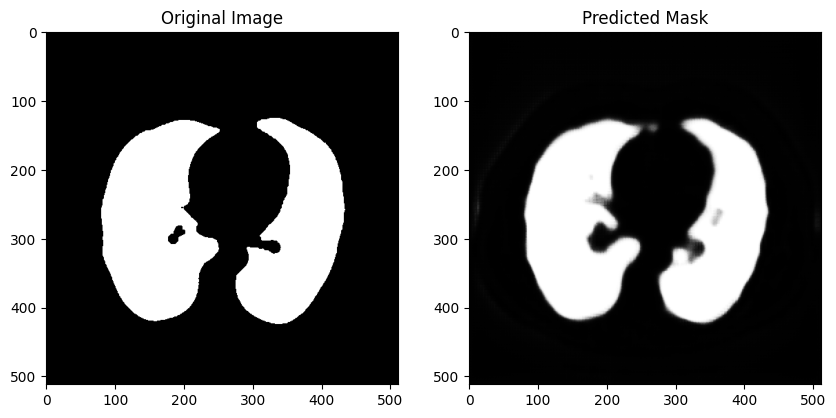

In [19]:
test_image, mask = test_dataset[0]
test_image = test_image.unsqueeze(0)

prediction = predict(model, test_image)

visualize_prediction(mask, prediction)

In [20]:
test_dice = evaluate_model(model, test_loader)
print(f'Test Dice Coefficient: {test_dice:.4f}')

Test Dice Coefficient: 0.9736
